# DQN Tutorial

Tutorial notebook to construct pipeline to train and test DQN agent. The agent have been trained and tested on gymnasium environments. 

## DQN (Deep Q Network)
- Mode-free
- Value-based
- Off-policy

## Tasks
- Acrobot-v1
- CartPole-v1

## Environment

In this notebook, we use Acrobot-v1 and CarPole-v1 environment from gymnasium. 

In [19]:
import gymnasium as gym
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from tqdm import tqdm
from datetime import datetime
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# define environment (editable)
#envname = "Acrobot-v1"
envname = "CartPole-v1"
env = gym.make(envname)

# plot settings
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
  from IPython import display

# device setting (cpu or cuda!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cuda


## Replay Memory

Replay memory stores transitions that agent observed. Stored transitions can be used in training agents later. 

Transition consists of (`state`, `action`, `reward`, `next_state`, `done`). 
- `state`: current state. agent act at this state. 
- `action`: action acted at current state. 
- `reward`: reward from the action. (not equal to goal)
- `next_state`: state after the action. zero state if terminated. 
- `done`: indicates whether the episode ended after the action. 

In this notebook, we sample batch from replay memory according to uniform sampling strategy to resolve data correlation problem. 

In [20]:
Transition = namedtuple("Transition", ("state", "action", "reward", "next_state", "done"))

class UniformReplayMemory(object):
  """
  Replay Memory that uses uniform sampling strategy. 
  """

  def __init__(self, capacity: int):
    """
    Set capacity of replay memory. 
    If new data stored in full memory, 
    the oldest data will be removed. 
    """
    self.memory = deque([], maxlen=capacity)

  def push(self, *args):
    """
    Push new transition data into memory. 
    - Transition: (state, action, reward, next_state, done)
    """
    self.memory.append(Transition(*args))

  def sample(self, batch_size: int):
    """
    Return random samples according to uniform sampling. 
    Return form is Transition of samples. 
    ex) return.state is list of states. 
    """
    sample = random.sample(self.memory, batch_size)
    return Transition(*zip(*sample))

  def __len__(self):
    """
    Return len of memory. 
    """
    return len(self.memory)


## Q Network

In this notebook, we use simple environment that have some real numbers as observations and few discrete actions. So, we use simple fully-connected network. 

In [21]:
class SimpleQNetwork(nn.Module):
  """
  Fully-connected network.
  """

  def __init__(self, n_observations: int, n_actions: int):
    """
    n_observations input channels and n_actions output channels. 
    """
    super(SimpleQNetwork, self).__init__()
    self.layer1 = nn.Linear(n_observations, 128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, n_actions)

  def forward(self, x: torch.Tensor):
    """
    Forward with relu activation. 
    """
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    return self.layer3(x)

## Training: Hyperparameters

- `NUM_EPISODES`: number of training episodes. 
- `TEST_EPISODES`: number of test episodes during training. 
- `TEST_FREQ`: testing frequency. 
- `MEMORY_CAPACITY`: maximum capacity of replay memory. 
- `BATCH_SIZE`: size of sampled transitions for training. 
- `GAMMA`: discount factor when calculating estimated goal. 
- `EPS_START`: starting epsilon value in e-greedy policy. 
- `EPS_END`: final epsilon value in e-greedy policy. 
- `EXPLORE_FRAME`: frame number that epsilon starts to decay. 
- `GREEDY_FRAME`: frame number that epsilon ends to decay
- `POLICY_UPDATE_FREQ`: frequency that policy net trains. 
- `TARGET_UPDATE_FREQ`: frequency that target net synchronized to policy net. 
- `LR`: learning rate. 

In [22]:
HyperParameter = namedtuple("HyperParameter", (
  "NUM_EPISODES",
  "TEST_EPISODES",
  "TEST_FREQ",
  "MEMORY_CAPACITY",
  "BATCH_SIZE",
  "GAMMA",
  "EPS_START",
  "EPS_END",
  "EXPLORE_FRAME",
  "GREEDY_FRAME",
  "POLICY_UPDATE_FREQ",
  "TARGET_UPDATE_FREQ",
  "LR"
))

# editable
hp = HyperParameter(
  NUM_EPISODES=600,
  TEST_EPISODES=5,
  TEST_FREQ=100,
  MEMORY_CAPACITY=10000,
  BATCH_SIZE=128,
  GAMMA=0.99,
  EPS_START=0.9,
  EPS_END=0.1,
  EXPLORE_FRAME=100,
  GREEDY_FRAME=5000,
  POLICY_UPDATE_FREQ=1,
  TARGET_UPDATE_FREQ=200,
  LR=0.0001
)

## Training: Utility Functions

- `select_action`: select agent's action in e-greedy policy. 
- `save_plot`: plot epsilon, loss, average frames and score. 
- `save_model`: store model, hyperparameters, and training info. 

In [23]:
# policy net and target net
n_observations = len(env.reset()[0])
n_actions = env.action_space.n

policy_net = SimpleQNetwork(n_observations, n_actions).to(device)
target_net = SimpleQNetwork(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# adamw optimizer
optimizer = optim.AdamW(policy_net.parameters(), lr=hp.LR, amsgrad=True)

# replay memory
memory = UniformReplayMemory(hp.MEMORY_CAPACITY)

# save directory
dirname = datetime.now().strftime("train-%Y%m%d-%H%M%S")
path = os.path.join(os.getcwd(), "dqn_tutorial", dirname)
os.makedirs(path)

# training variables
train_epsilons = []
train_losses = []
train_frames = []
train_scores = []
test_frames = []
test_scores = []
epsilon = hp.EPS_START
epsilon_decay = (hp.EPS_START - hp.EPS_END) / (hp.GREEDY_FRAME - hp.EXPLORE_FRAME)
steps = 0

def select_action(state: np.ndarray):
  """
  Select agent's action by e-greedy policy. 
  """
  sample = random.random()
  if sample > epsilon:
    # greedy action
    with torch.no_grad():
      return torch.argmax(policy_net(state), dim=1, keepdim=True)
  else:
    # random action
    return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def save_plot():
  """
  Plot loss, epsilon, average frames, and score and save the figures. 
  """
  plt.figure(figsize=(16, 12))
  plt.clf()
  plt.ion()
  
  plt.subplot(2, 2, 1)
  plt.title("Epsilon")
  plt.xlabel("Frame")
  plt.ylabel("Epsilon")
  plt.plot(train_epsilons, label="train")
  plt.legend()
  
  plt.subplot(2, 2, 2)
  plt.title("Loss")
  plt.xlabel("Learning Step")
  plt.ylabel("Loss")
  plt.plot(train_losses, label="train")
  if len(train_losses) >= 100:
    train_losses_avg = torch.tensor(train_losses).unfold(0, 100, 1).mean(1)
    plt.plot(list(range(99, len(train_losses_avg) + 99)), train_losses_avg, label="train_avg")
  plt.legend()
  
  plt.subplot(2, 2, 3)
  plt.title("# of Frames")
  plt.xlabel("Episode")
  plt.ylabel("# of Frames")
  plt.plot(train_frames, label="train")
  plt.plot([i * hp.TEST_FREQ - 1 for i in range(1, len(test_frames) + 1)], test_frames, label="test")
  plt.legend()
  
  plt.subplot(2, 2, 4)
  plt.title("Score")
  plt.xlabel("Episode")
  plt.ylabel("Score")
  plt.plot(train_scores, label="train")
  plt.plot([i * hp.TEST_FREQ - 1 for i in range(1, len(test_scores) + 1)], test_scores, label="test")
  plt.legend()
  
  plt.ioff()
  plt.savefig(os.path.join(path, "plot.png"))
  
  if is_ipython:
    display.clear_output(wait=True)
    display.display(plt.gcf())

def save_model():
  """
  Save model, hyperparameters, and training info.
  """
  # save model
  torch.save({
    "policy_net": policy_net.state_dict(),
    "target_net": target_net.state_dict()
  }, os.path.join(path, "model.pt"))
  
  # save hyperparameters
  with open(os.path.join(path, "hparam.json"), "w") as w:
    json.dump(hp._asdict(), w, indent=2)
  
  # save training info
  with open(os.path.join(path, "info.json"), "w") as w:
    json.dump(dict([
      ("env", envname), 
      ("train_epsilons", train_epsilons), 
      ("train_losses", train_losses), 
      ("train_frames", train_frames), 
      ("test_frames", test_frames), 
      ("train_scores", train_scores), 
      ("test_scores", test_scores), 
      ("steps", steps)
    ]), w, indent=2)

## Training: Optimizing Function

- `optimize_model`: execute one step of optimizing. We use Huber loss in this notebook.
  $$ TD = Q_{policy}(s_t, a_t) - (r_t + \gamma max_a Q_{target}(s_{t+1}, a)) $$
  $$ L(TD) = \begin{cases} 
    \frac{1}{2}{TD}^2 & \text{for } |TD| \leq 1 \\ 
    |TD| - \frac{1}{2} & \text{otherwise}
  \end{cases} $$

In [24]:
def optimize_model():
  """
  Optimize policy model. 
  """
  # if not enough data, quit
  if len(memory) < hp.BATCH_SIZE:
    return
  
  # sample batch
  batch = memory.sample(hp.BATCH_SIZE)
  
  # get training data from the batch
  state_batch = torch.cat(batch.state)
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)
  next_state_batch = torch.cat(batch.next_state)
  done_batch = torch.cat(batch.done)
  
  # calc Q(s_t, a)
  current_q = policy_net(state_batch).gather(1, action_batch)
  
  # calc r_t + gamma * max_a Q_target(s_t+1, a)
  with torch.no_grad():
    next_q = target_net(next_state_batch).max(1).values
  expected_q = reward_batch + hp.GAMMA * (1.0 - done_batch) * next_q
  expected_q = expected_q.unsqueeze(1)
  
  # calculate loss
  criterion = nn.HuberLoss()
  loss = criterion(current_q, expected_q)
  
  train_losses.append(loss.item())
  
  # optimize model
  optimizer.zero_grad()
  loss.backward()
  torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
  optimizer.step()

## Training: Testing Function

- `test_model`: run policy model in the environment with greedy policy. 

In [25]:
def test_model():
  """
  Test policy model and save the result in training variables. 
  """
  # testing variables
  frames = []
  scores = []
  
  # repeat for TEST_EPISODES episodes
  for _ in range(1, hp.TEST_EPISODES + 1):
    # initialize environment and state
    state, _ = env.reset()
    state = torch.tensor(np.array(state), device=device, dtype=torch.float32).unsqueeze(0)
    score = 0
    
    # start an episode
    for frame in count():
      # select greedy action
      with torch.no_grad():
        action = torch.argmax(policy_net(state), dim=1, keepdim=True)
      
      # act to next state
      observation, reward, terminated, truncated, _ = env.step(action.item())
      score += reward
      reward = torch.tensor([reward], device=device)
      done = terminated or truncated
      
      # update state
      state = torch.tensor(np.array(observation), device=device, dtype=torch.float32).unsqueeze(0)

      # check end condition
      if done:
        frames.append(frame)
        scores.append(score)
        break
      
  # add to training variables
  test_frames.append(np.mean(np.array(frames)))
  test_scores.append(np.mean(np.array(scores)))

## Training

In training, simulate agent in the environment to create transitions, and trains the agent using `optimize_model()` function. 

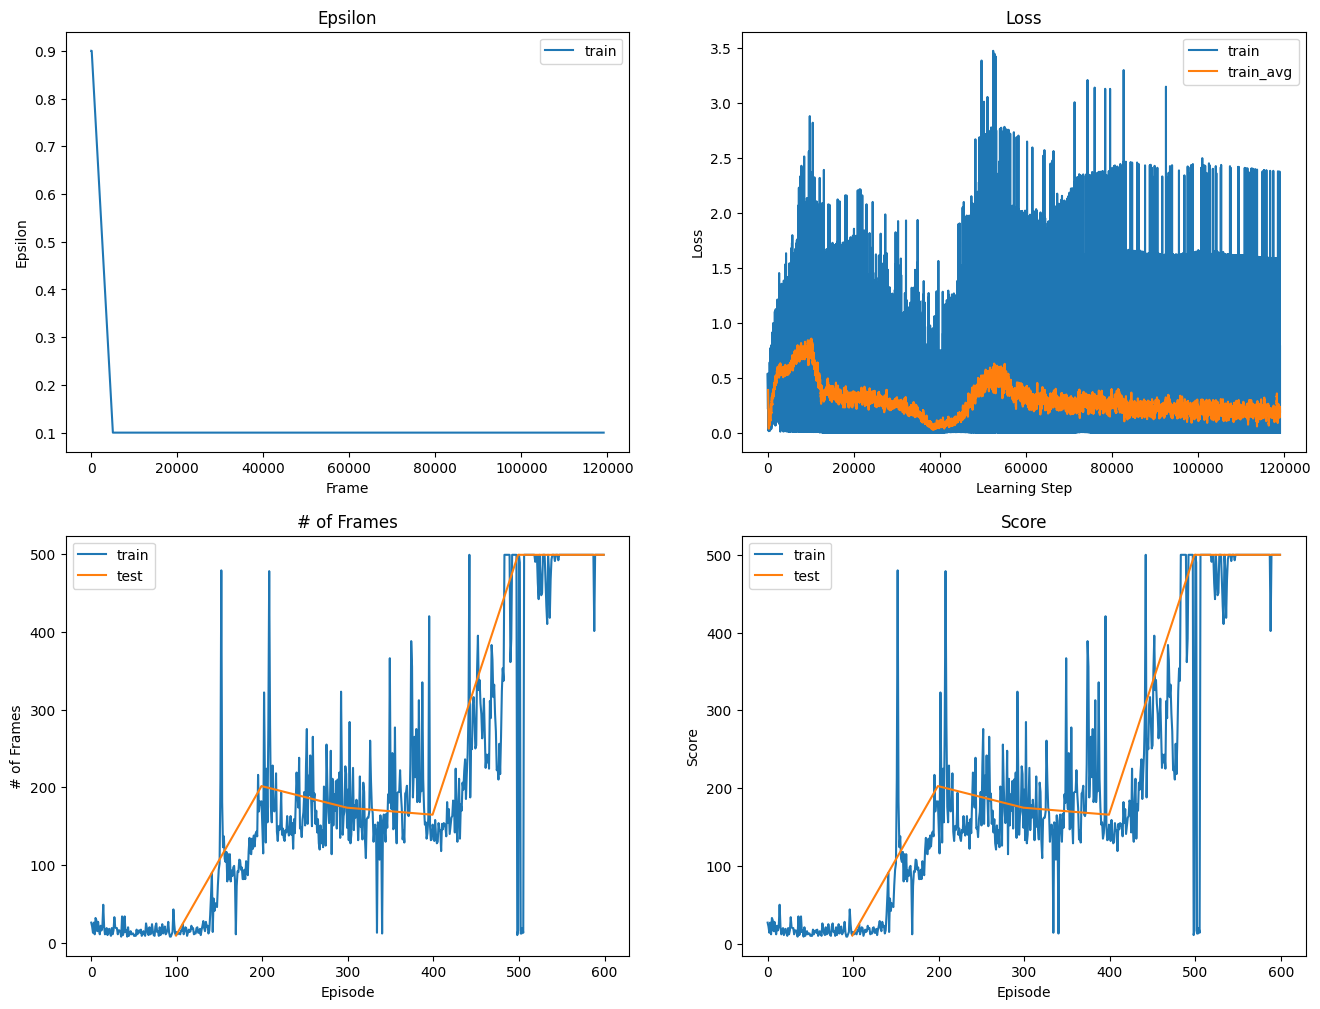

In [26]:
for episode in tqdm(range(1, hp.NUM_EPISODES + 1)):
  # initialize environment and state
  state, _ = env.reset()
  state = torch.tensor(np.array(state), device=device, dtype=torch.float32).unsqueeze(0)
  score = 0
  
  # start an episode
  for frame in count():
    # select greedy action
    action = select_action(state)
    
    # update epsilon
    train_epsilons.append(epsilon)
    steps += 1
    if hp.EXPLORE_FRAME <= steps < hp.GREEDY_FRAME:
      epsilon -= epsilon_decay
    
    # act to next state
    observation, reward, terminated, truncated, _ = env.step(action.item())
    score += reward
    reward = torch.tensor([reward], device=device, dtype=torch.float32)
    done = terminated or truncated
    
    # get next state
    next_state = torch.tensor(np.array(observation), device=device, dtype=torch.float32).unsqueeze(0)

    # add transition to the memory
    memory.push(state, action, reward, next_state, torch.tensor([1.0 if done else 0.0], device=device))
    
    # update state
    state = next_state
    
    # if time to update policy net, optimize
    if steps % hp.POLICY_UPDATE_FREQ == 0:
      optimize_model()
    
    # if time to update target net, synchronize
    if steps % hp.TARGET_UPDATE_FREQ == 0:
      target_net.load_state_dict(policy_net.state_dict())
    
    # check end condition
    if done:
      train_scores.append(score)
      train_frames.append(frame)
      if episode % hp.TEST_FREQ == 0:
        test_model()
        save_plot()
        save_model()
      break

save_plot()
save_model()

## Test

In this block, trained agent plays in the environment. We can see rendered environment played by the agent. 

In [27]:
env = gym.make(envname, render_mode="human")

scores = []

# if you want to load from trained model, edit this (editable)
load_dirname = None

if load_dirname is not None:
  # load models
  path = os.path.join(os.getcwd(), "dqn_tutorial", load_dirname)
  checkpoint = torch.load(os.path.join(path, "model.pt"), map_location=device)
  
  policy_net.load_state_dict(checkpoint["policy_net"])
  target_net.load_state_dict(checkpoint["target_net"])

# repeat for TEST_EPISODES episodes
for episode in range(1, hp.TEST_EPISODES + 1):
  # initialize environment and state
  state, _ = env.reset()
  state = torch.tensor(np.array(state), device=device, dtype=torch.float32).unsqueeze(0)
  score = 0
  
  # start an episode
  for _ in count():
    # select greedy action
    with torch.no_grad():
      action = torch.argmax(policy_net(state), dim=1, keepdim=True)
    
    # act to next state
    observation, reward, terminated, truncated, _ = env.step(action.item())
    score += reward
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated
    
    # update state
    state = torch.tensor(np.array(observation), device=device, dtype=torch.float32).unsqueeze(0)

    # check end condition
    if done:
      print(f"Episode {episode}: {score}")
      scores.append(score)
      break

env.close()

print(f"Average: {sum(scores) / hp.TEST_EPISODES}")
print(f"Max: {max(scores)}")
print(f"Min: {min(scores)}")

Episode 1: 500.0
Episode 2: 500.0
Episode 3: 500.0
Episode 4: 500.0
Episode 5: 500.0
Average: 500.0
Max: 500.0
Min: 500.0
